In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.fft import fftn, ifftn, fftfreq,fft
#from spectral_derivative import  calc_deriv_fftn_with_ext#,calc_deriv_in_frequency_space
import os
import pynumdiff

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12


# Calculates the spectral derivative for n-dimensional input and order
# Takes ax and d as liste e.g. ax = [0], d =[0.1]
# From my bachelor thesis: Linear Physical Law Learning
#https://github.com/HillaryHauger/linear-physical-law-learning/blob/main/frequency_method_functions.ipynb

In [39]:
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise

def compute_distance_svs(u,dx,fd_orders=range(2,8)):
    distance_svs = []
    for fd_order in fd_orders:
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                             drop_endpoints=False)._differentiate(u, dx)
    
        u_flat, u_x_flat = u.flatten(), ux.flatten()
        features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
        svs = svd(features, compute_uv=False)
        distance_svs.append(svs[-1])
    return distance_svs

# Exponential function: $u(t,x)=exp(x+at)$

In [47]:
experiment_name = "linear_nonunique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_nonunique_1
exp(-0.319366915390924*t + x)


Noise level: 0
1 [6.04192790e+02 1.23493139e-10]
Noise level: 1e-10
2 [6.04192790e+02 1.17495711e-05]
Noise level: 1e-09
2 [6.04192790e+02 1.24169651e-04]
Noise level: 1e-08
2 [6.04192769e+02 1.07647883e-03]
Noise level: 1e-07
2 [6.04192778e+02 1.12021469e-02]
Noise level: 1e-06
2 [6.04192908e+02 1.21603751e-01]
Noise level: 1e-05
2 [604.18385005   1.19463406]
Noise level: 0.0001
2 [604.22299122  11.73863953]
Noise level: 0.001
2 [616.74567146 121.685872  ]
Noise level: 0.01
2 [1666.84148811  413.05301298]
Noise level: 0.1
2 [16714.25524143   429.23409282]


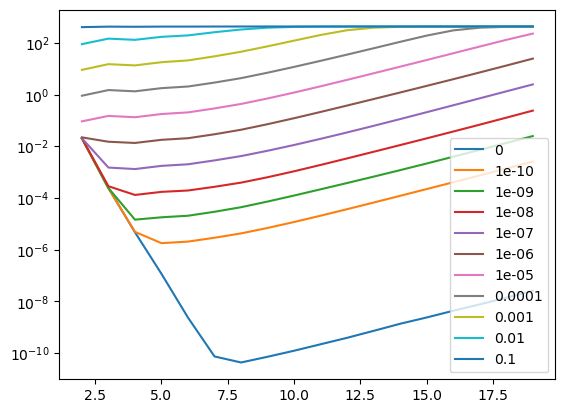

In [48]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    ux_noise = ps.FiniteDifference(order=10, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))
    m=20
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=range(2,m))
    plt.plot(range(2,m), distance_svs_noise,label=str(target_noise))
    plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")

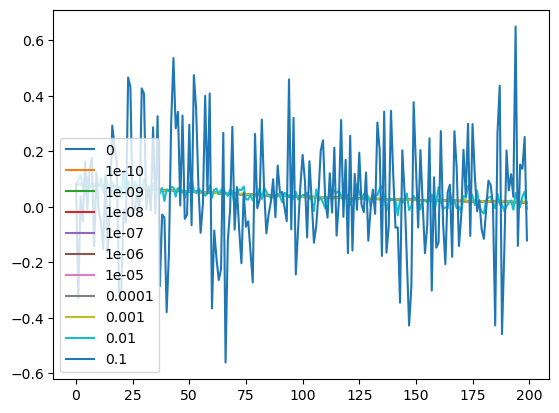

In [49]:
for target_noise in noise_levels:
    u_noise = add_noise(u,target_noise)
    plt.plot(u_noise[0],label=str(target_noise))
plt.legend()
#plt.savefig("noise_levels_func.png")
plt.show()


### Try calculationg the derivative with the Fourier Transform

In [50]:
from spectral_derivative import calc_deriv_fftn_with_ext
ux_fft = calc_deriv_fftn_with_ext(u,[x,t],[0],[dx])

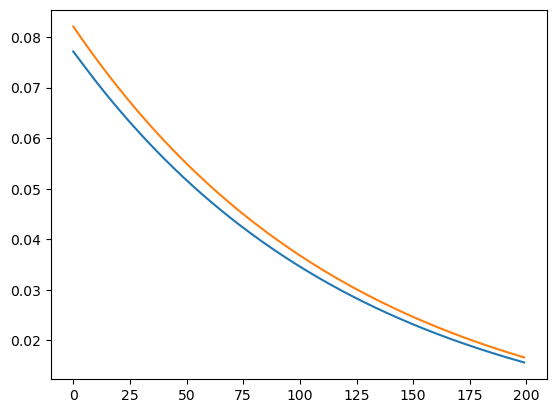

In [51]:
plt.plot(ux_fft[0])
plt.plot(u[0])

In [55]:
from spectral_derivative import calc_deriv_fftn_with_ext
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    #ux_noise = ps.FiniteDifference(order=10, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    ux_fft = calc_deriv_fftn_with_ext(u_noise,[x,t],[0],[dx])
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_fft.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))


Noise level: 0
2 [603.63649902   1.75381325]
Noise level: 1e-10
2 [603.63649902   1.75381325]
Noise level: 1e-09
2 [603.63649899   1.75381332]
Noise level: 1e-08
2 [603.63649879   1.75381515]
Noise level: 1e-07
2 [603.63650001   1.75381289]
Noise level: 1e-06
2 [603.6365434    1.75379524]
Noise level: 1e-05
2 [603.63692879   1.76496624]
Noise level: 0.0001
2 [603.64300426   2.7473812 ]
Noise level: 0.001
2 [604.00661331  21.61034327]
Noise level: 0.01
2 [645.34362273 201.6182216 ]
Noise level: 0.1
2 [3079.60281784  425.06594198]


# Exponential function: $u(t,x)=(bt+x)exp(at)$

In [8]:
experiment_name = "linear_unique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_unique_1
(0.636681980815249*t + x)*exp(0.319366915390924*t)


Noise level: 0
2 [1605.61281152  297.90744974]
Noise level: 1e-10
2 [1605.61281165  297.90744944]
Noise level: 1e-09
2 [1605.61281335  297.90745505]
Noise level: 1e-08
2 [1605.61279183  297.90749596]
Noise level: 1e-07
2 [1605.61284578  297.90704638]
Noise level: 1e-06
2 [1605.61294114  297.91352616]
Noise level: 1e-05
2 [1605.6136265   297.91849119]
Noise level: 0.0001
2 [1605.567211    303.47586774]
Noise level: 0.001
2 [1616.10980366  669.48056331]
Noise level: 0.01
2 [5825.36742296 1536.36434764]
Noise level: 0.1
2 [60146.10132328  1548.04967793]


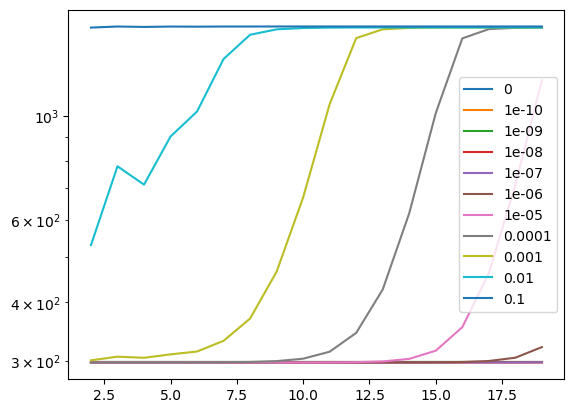

In [9]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    ux_noise = ps.FiniteDifference(order=10, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))
    m=20
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=range(2,m))
    plt.plot(range(2,m), distance_svs_noise,label=str(target_noise))
    plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")

## Examplary Derivative Calculaton: 
Problem: no exact calucaltion despite extension and no noise?

In [35]:
from spectral_derivative import flattenandextendfunc_1d,calc_deriv_fftn

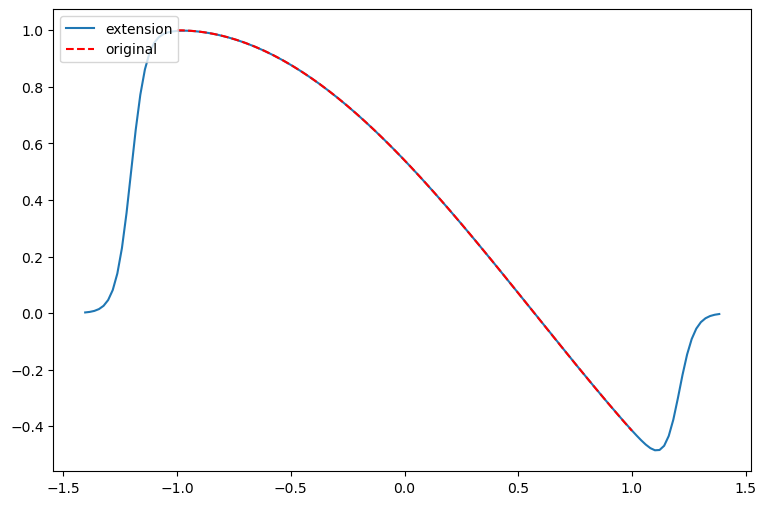

In [36]:
# Do the same for one dimensional function
n= 100# amount of points
L=2#length of domain
dx = L/n
const=0#np.pi/2
a=1
b=1
x = np.linspace(-L/2+const, L/2+const, num=n)
#f = np.exp(a*x+b)
#dfdx = a*np.exp(a*x+b)
f = np.cos(a*x+b)
dfdx = -a*np.sin(a*x+b)
dfdx_fd = ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(f, dx)


newf,newx,newn= flattenandextendfunc_1d(f,x)

plt.figure(figsize=(9,6))
plt.plot(newx,newf, label='extension')
plt.plot(x,f,'--',color='red',label='original')
plt.legend(loc=2)
plt.savefig("Images/Extension.png")
plt.show()


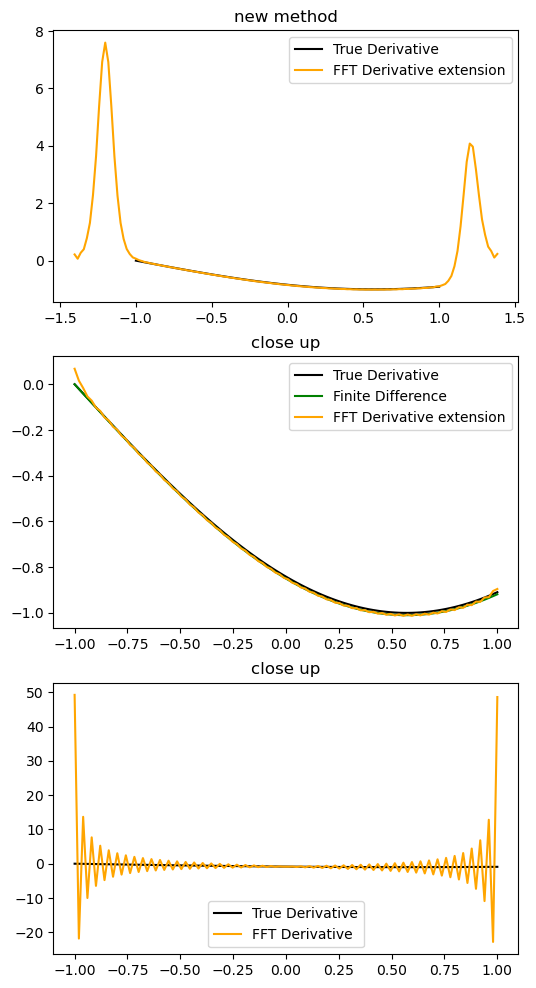

In [29]:


#Check if calculating the derivative holds
dfdx_FFT = calc_deriv_fftn(f,[0], [dx])
newdfdx_FFT = calc_deriv_fftn(newf,[0], [dx])

# Plot Derivatives
plt.figure(figsize=(6,12))
plt.subplot(3,1,1)
plt.title("new method")
plt.plot(x,dfdx, color='k', label ='True Derivative')
plt.plot(newx,newdfdx_FFT,color='orange', label = 'FFT Derivative extension')
plt.legend(loc=0)

plt.subplot(3,1,2)
plt.title("close up")
plt.plot(x,dfdx, color='k', label ='True Derivative')
plt.plot(x,dfdx_fd, color='green', label ='Finite Difference')
plt.plot(x,newdfdx_FFT[newn:newn+f.size],color='orange', label = 'FFT Derivative extension')
plt.legend(loc=0)

plt.subplot(3,1,3)
plt.title("close up")
plt.plot(x,dfdx, color='k', label ='True Derivative')
plt.plot(x,dfdx_FFT,color='orange', label = 'FFT Derivative')
plt.legend(loc=0)
plt.savefig("Images/derivative_calc.png")

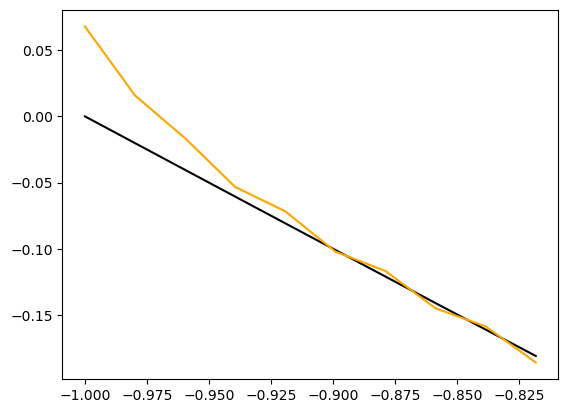

In [33]:
n=10
#Why do I get this artefacts?? 
plt.plot(x[:n],dfdx[:n], color='k', label ='True Derivative')
plt.plot(x[:n],newdfdx_FFT[newn:newn+f.size][:n],color='orange', label = 'FFT Derivative extension')
plt.savefig("Images/derivative_calc_closeup.png")